See <a href="https://huggingface.co/datasets">Huggingface Datasets</a>

In [1]:
import datasets
from   datasets import list_datasets, load_dataset
from   huggingface_hub import notebook_login
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.dummy import DummyClassifier
from   sklearn.linear_model import LogisticRegression
from   sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score)
from   sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn.functional as F
from   torch.nn.functional import cross_entropy
from   transformers import (
    AutoModel, AutoModelForSequenceClassification, AutoTokenizer,
    DistilBertTokenizer, pipeline, TFAutoModel) 
    #, Trainer, TrainingArguments) # no M1 Wheel yet
#from umap import UMAP # no M1 Wheel yet

In [2]:
datasets = list_datasets()
print(f'There are {len(datasets)} datsets available, including')
for i in range(10):
    print(f'  - {datasets[i]}')

There are 2436 datsets available, including
  - 0n1xus/codexglue
  - 0n1xus/pytorrent-standalone
  - AConsApart/anime_subtitles_DialoGPT
  - AHussain0418/day2_data
  - AHussain0418/day4data
  - AHussain0418/demo_data
  - AI-Sweden/SuperLim
  - AI-it/khs_service_test
  - AI-it/korean-hate-speech
  - ARKseal/YFCC14M_subset_webdataset


In [3]:
metadata = list_datasets(with_details=True)[datasets.index('emotion')]
print(metadata.description)
print()
print('\n'.join(metadata.citation.split('\n')[:8]))

Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.

@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",


In [4]:
emotions = load_dataset('emotion')
emotions

Using custom data configuration default
Reusing dataset emotion (/Users/damiansp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}

In [10]:
train_ds[1:6]

{'text': ['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was'],
 'label': [0, 3, 2, 3, 0]}

In [11]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(i):
    return emotions['train'].features['label'].int2str(i)

In [13]:
df['label_name'] = df.label.apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


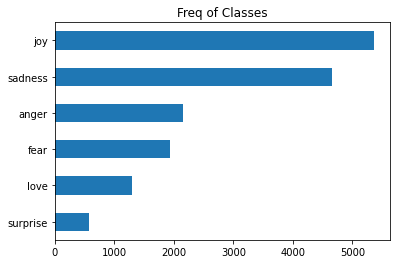

In [14]:
df.label_name.value_counts(ascending=True).plot.barh()
plt.title('Freq of Classes');

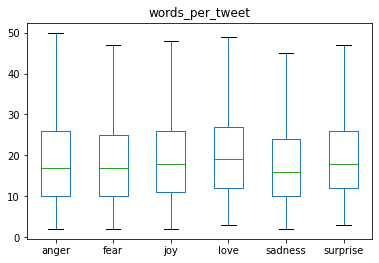

In [15]:
df['words_per_tweet'] = df.text.str.split().apply(len)
df.boxplot(
    'words_per_tweet', by='label_name', showfliers=False, grid=False)
plt.suptitle('')
plt.xlabel('');

In [16]:
emotions.reset_format()

## From Text to Tokens
### Character Tokenization

In [17]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [18]:
token2idx = {ch: idx 
             for idx, ch in enumerate(sorted(set(tokenized_text)))}
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [19]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [20]:
categorical_df = pd.DataFrame({
    'name': ['Bumblebee', 'Optimus Prime', 'Megatron'],
    'label': [0, 1, 2]})
categorical_df

,name,label
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [21]:
pd.get_dummies(categorical_df.name)

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [22]:
input_ids = torch.tensor(input_ids)
one_hot = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot.shape

torch.Size([38, 20])

In [23]:
print(f'Token: {tokenized_text[0]}')
print(f'Index: {input_ids[0]}')
print(f'One-Hot: {one_hot[0]}')

Token: T
Index: 5
One-Hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [24]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword Tokenization 

In [25]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [26]:
# Equivalent:
#tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [27]:
text

'Tokenizing text is a core task of NLP.'

In [28]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [29]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [30]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [31]:
tokenizer.vocab_size

30522

In [32]:
tokenizer.model_max_length

512

In [33]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [34]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [35]:
emotions['train'][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [36]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [37]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded['train'].column_names

Loading cached processed dataset at /Users/damiansp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-38140d02b4384963.arrow
Loading cached processed dataset at /Users/damiansp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-1a30bb3aa6bcddea.arrow
Loading cached processed dataset at /Users/damiansp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a9e5994305d1cb35.arrow


['attention_mask', 'input_ids', 'label', 'text']

## Transformers as Feature Extractors
### Using Pretrained Models

In [38]:
mod_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mod = AutoModel.from_pretrained(mod_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
# TensorFlow equivalent:
#tf_mod = TFAutoModel.from_pretrained(mod_ckpt)

# If original mod exists in only one architecture, convert:
#tf_xlmr = TFAutoModel.from_pretrained('xlm-roberta-base', from_pt=True)

In [40]:
text = 'this is only a test'
inputs = tokenizer(text, return_tensors='pt')
f'Input tensor shape: {inputs["input_ids"].size()}' 
# batch size, n tokens

'Input tensor shape: torch.Size([1, 7])'

In [41]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = mod(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1106, -0.0890,  0.0291,  ..., -0.0389,  0.1400,  0.4883],
         [-0.2092, -0.4512, -0.0368,  ..., -0.1308,  0.3934,  0.3992],
         [-0.2757, -0.3504,  0.2033,  ..., -0.0206, -0.0181,  0.8520],
         ...,
         [-0.1771, -0.2020,  0.3657,  ...,  0.0311, -0.0705,  0.8684],
         [ 0.3047, -0.3977, -0.2155,  ..., -0.2632,  0.0557, -0.3890],
         [ 0.9571,  0.0864, -0.4193,  ...,  0.1619, -0.6434, -0.1724]]]), hidden_states=None, attentions=None)


In [42]:
outputs.last_hidden_state.size() # batch, n tokens, hidden dim

torch.Size([1, 7, 768])

In [43]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [44]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = mod(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [45]:
emotions_encoded.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, 
                                       batched=True)
emotions_hidden['train'].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

### Create a feature matrix

In [47]:
dsets = ['train', 'validation']
X_train, X_valid = [np.array(emotions_hidden[dset]['hidden_state'])
                    for dset in dsets]
y_train, y_valid = [np.array(emotions_hidden[dset]['label'])
                    for dset in dsets]
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the Training Set

In [48]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled) # 2D proj
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

NameError: name 'UMAP' is not defined

NameError: name 'df_emb' is not defined

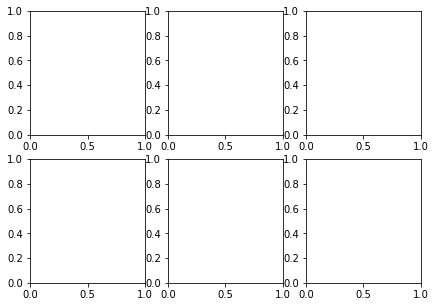

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    sub = df_emb[df_emb.label == i]
    axes[i].hexbin(
        sub.X, sub.Y, cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axis[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout();

In [54]:
# TODO: UMAP alternate

### Train a Simple Classifier

In [55]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_valid, y_valid) # accuracy

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6045

In [56]:
# But recall, this is an unbalanced multi-class set
for strategy in ['most_frequent', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(X_train, y_train)
    score = dummy.score(X_valid, y_valid)
    print(f'{strategy}: {score}')

most_frequent: 0.352
uniform: 0.1625


In [57]:
def plot_confusion_matrix(actual, preds, labels):
    cm = confusion_matrix(actual, preds, normalize='true')
    fix, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

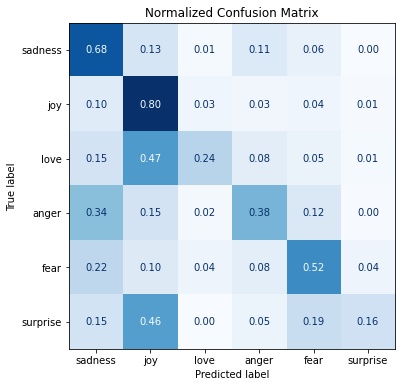

In [58]:
preds = log_reg.predict(X_valid)
plot_confusion_matrix(y_valid, preds, labels)

## Fine Tuning Transformers
### Loading a Pretrained Model

In [59]:
n_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=n_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

### Define Performance Metrics

In [60]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.prdictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, pred)
    return {'accuracy': acc, 'f1': f1}

In [61]:
notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Login successful
Your token has been saved to /Users/damiansp/.huggingface/token
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default


In [62]:
BATCH = 64
LOG_STEPS = len(emotions_encoded['train']) // BATCH
mod_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=mod_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=LOG_STEPS,
    push_to_hub=True,
    log_level='error')

NameError: name 'TrainingArguments' is not defined

In [ ]:
trainer = Trainer(
    model=mod,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer)
trainer.train()

In [ ]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

In [ ]:
preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(preds, y_valid, labels);

In [ ]:
# TF/Keras equivalent
#from transformers import TFAutoModelForSequenceClassification

#tf_mod = TFAutoModelForSequenceClassification.from_pretrained(
#    model_ckpt, num_labels=num_labels)

In [ ]:
#tokenizer_columns = tokenizer.model_input_names
#tf_train_dataset = emotions_encoded['train'].to_tf_dataset(
#    columns=tokenizer_columns,
#    label_cols=['label'], 
#    shuffle=True,
#    batch_size=BATCH)
#tf_eval_dataset = emotions_encoded['validation'].to_tf_dataset(
#    columns=tokenizer_columns,
#    label_cols=['label'], 
#    shuffle=False,
#    batch_size=BATCH)

In [ ]:
#import tensorflow as tf

#tf_mod.compile(
#    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(
#        from_logits=True),
#    metrics=tf.metrics.SparseCategoricalAccuracy())
#tf_mod.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

### Error Analysis

In [ ]:
def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = crass_entropy(
            output.logits, batch['label'].to(device), reuction='none')
    return {'loss': loss.cpu().numpy(),
            'predicted_label': pred_label.cpu().numpy()}

In [ ]:
# Convert dataset back to PyTorch tensors
emotions_encoded.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_encoded['validation'] = emotions_encoded['validation'].map(
    foraward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(
    label_int2str)

In [ ]:
df_test.sort_values('loss', ascending=False).head(10)

In [ ]:
df_test.sort_values('loss').head(10)

In [ ]:
trainer.push_to_hub(commit_message='Training completed!')

In [63]:
HUB_USERNAME = 'damiansp'

In [ ]:
model_id = f'{HUB_USERNAME}/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model=model_id)

In [ ]:
custom_tweet = 'I saw a film today, oh boy!'
preds = classifier(custom_tweet, return_all_scores=True)

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df.score, color='C0')
plt.title(custom_tweet)
plt.ylabel('Class Prob.')